<a href="https://colab.research.google.com/github/erinmcmahon26/Chatbot/blob/main/NN_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import json
import random
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
import spacy
from spacy.matcher import Matcher 

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout

from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=4684784382254775758d63b62d39fa5677b38172cb6a6f4454c5295737183940
  Stored in directory: /tmp/pip-ephem-wheel-cache-34fvzah7/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
import spacy.cli

spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
nlp = spacy.load('en_core_web_lg')

In [5]:
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [6]:
df = pd.read_json('https://raw.githubusercontent.com/erinmcmahon26/Chatbot/main/zelda.json', orient = 'index')

In [7]:
df.head()

0
The Legend of Zelda: Breath of the Wild             The Legend of Zelda: Breath of the Wild is a 2...
Untitled The Legend of Zelda: Breath of the Wil...  An untitled sequel to the 2017 action-adventur...
The Legend of Zelda                                 The Legend of Zelda is a high fantasy action-a...
Universe of The Legend of Zelda                     The Legend of Zelda is a video game franchise ...
Hyrule Warriors: Age of Calamity                    Hyrule Warriors: Age of Calamity is a hack-and...

In [8]:
df.reset_index(inplace = True)

In [9]:
df.rename(columns = {'index':'doc_title', 0:'doc_text'}, inplace = True)

In [10]:
df.head()

doc_title  \
0            The Legend of Zelda: Breath of the Wild   
1  Untitled The Legend of Zelda: Breath of the Wi...   
2                                The Legend of Zelda   
3                    Universe of The Legend of Zelda   
4                   Hyrule Warriors: Age of Calamity   

                                            doc_text  
0  The Legend of Zelda: Breath of the Wild is a 2...  
1  An untitled sequel to the 2017 action-adventur...  
2  The Legend of Zelda is a high fantasy action-a...  
3  The Legend of Zelda is a video game franchise ...  
4  Hyrule Warriors: Age of Calamity is a hack-and...

In [11]:
df['doc_title']

0               The Legend of Zelda: Breath of the Wild
1     Untitled The Legend of Zelda: Breath of the Wi...
2                                   The Legend of Zelda
3                       Universe of The Legend of Zelda
4                      Hyrule Warriors: Age of Calamity
5                                                Urbosa
6                       List of Game of the Year awards
7                                        Princess Zelda
8                                                 Mipha
9                            Link (The Legend of Zelda)
10                                         Prince Sidon
11                                      Nintendo Switch
12                                    Horizon Zero Dawn
13                                       Genshin Impact
14                                 The Game Awards 2017
15                                 Hidemaro Fujibayashi
16                                      Sonic Frontiers
17                                              

In [34]:
#delete docs not related to video game
df.drop([12, 13, 16, 24, 29])

doc_title  \
0             The Legend of Zelda: Breath of the Wild   
1   Untitled The Legend of Zelda: Breath of the Wi...   
2                                 The Legend of Zelda   
3                     Universe of The Legend of Zelda   
4                    Hyrule Warriors: Age of Calamity   
5                                              Urbosa   
6                     List of Game of the Year awards   
7                                      Princess Zelda   
8                                               Mipha   
9                          Link (The Legend of Zelda)   
10                                       Prince Sidon   
11                                    Nintendo Switch   
14                               The Game Awards 2017   
15                               Hidemaro Fujibayashi   
17                                              Ganon   
18                                               Cemu   
19                                       Master Sword   
20                                         Open world   
21                  List of The Legend of Zelda media   
22                  Characters of The Legend of Zelda   
23                                  Elizabeth Maxwell   
25  The Legend of Zelda: Breath of the Wild – Crea...   
26                                               Impa   
27                                Patricia Summersett   
28                                        Eiji Aonuma   

                                             doc_text  
0   The Legend of Zelda: Breath of the Wild is a 2...  
1   An untitled sequel to the 2017 action-adventur...  
2   The Legend of Zelda is a high fantasy action-a...  
3   The Legend of Zelda is a video game franchise ...  
4   Hyrule Warriors: Age of Calamity is a hack-and...  
5   Urbosa is a fictional character from Nintendo'...  
6   Game of the Year (GotY) is an award given by v...  
7   Princess Zelda is the titular character in Nin...  
8   Mipha is a fictional character in Nintendo's T...  
9   Link is a fictional character and the protagon...  
10  Prince Sidon ( SY-don) is a fictional characte...  
11  The Nintendo Switch is a video game console de...  
14  The Game Awards 2017 was an award show that ho...  
15  Hidemaro Fujibayashi (藤林 秀麿, Fujibayashi Hidem...  
17  Ganon is a fictional monster and the main anta...  
18  Cemu is a closed-source Wii U video game conso...  
19  The Master Sword (マスターソード, Masutā Sōdo) is a f...  
20  In video games, an open world is a game mechan...  
21  The Legend of Zelda is a video game series cre...  
22  The Legend of Zelda is a high-fantasy video ga...  
23  Elizabeth Maxwell is an American voice actress...  
25  The Legend of Zelda: Breath of the Wild – Crea...  
26  Impa is a recurring fictional character in Nin...  
27  Patricia Summersett (born March 15, 1982) is a...  
28  Eiji Aonuma (Japanese: 青沼 英二, Hepburn: Aonuma ...

In [13]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " "+ prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [14]:
def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                   {'DEP':'prep','OP':"?"},
                   {'DEP':'agent','OP':"?"},  
                   {'POS':'ADJ','OP':"?"}] 
        
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except Exception as e:
        pass

In [15]:
all_docs = ' '.join(df['doc_text'])
all_docs[0]

'T'

In [16]:
docs = nlp(all_docs)

In [17]:
sentences = [str(x) for x in list(docs.sents)]

In [18]:
# get entity pairs for all docs
entity_pairs = []

for i in tqdm(sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 5930/5930 [00:58<00:00, 101.69it/s]


In [19]:
relations = [get_relation(i) for i in tqdm(sentences)]

100%|██████████| 5930/5930 [00:53<00:00, 111.85it/s]


In [20]:
source = [i[0] for i in entity_pairs]

In [21]:
target = [i[1] for i in entity_pairs]

In [22]:
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [41]:
kg_df.head(10)

source                  target             edge
0                                               zelda        legend of
1  2017 action adventure game         nintendo switch               is
2                        game          zelda timeline               is
3                amnesiac who  hundred calamity ganon         controls
4                                      original  1986       similar to
5               zelda players             open  world     given little
6                       tasks         solving  quests          include
7            main story quest      nonlinear  fashion  is unstructured
8           larger game world              five  fans             took
9                    nintendo      chemistry  engines       introduced

In [24]:
for col in kg_df:
  kg_df[col] = kg_df[col].str.lower()

In [25]:
kg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5930 entries, 0 to 5929
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  5930 non-null   object
 1   target  5930 non-null   object
 2   edge    5930 non-null   object
dtypes: object(3)
memory usage: 139.1+ KB


In [26]:
kgraph = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

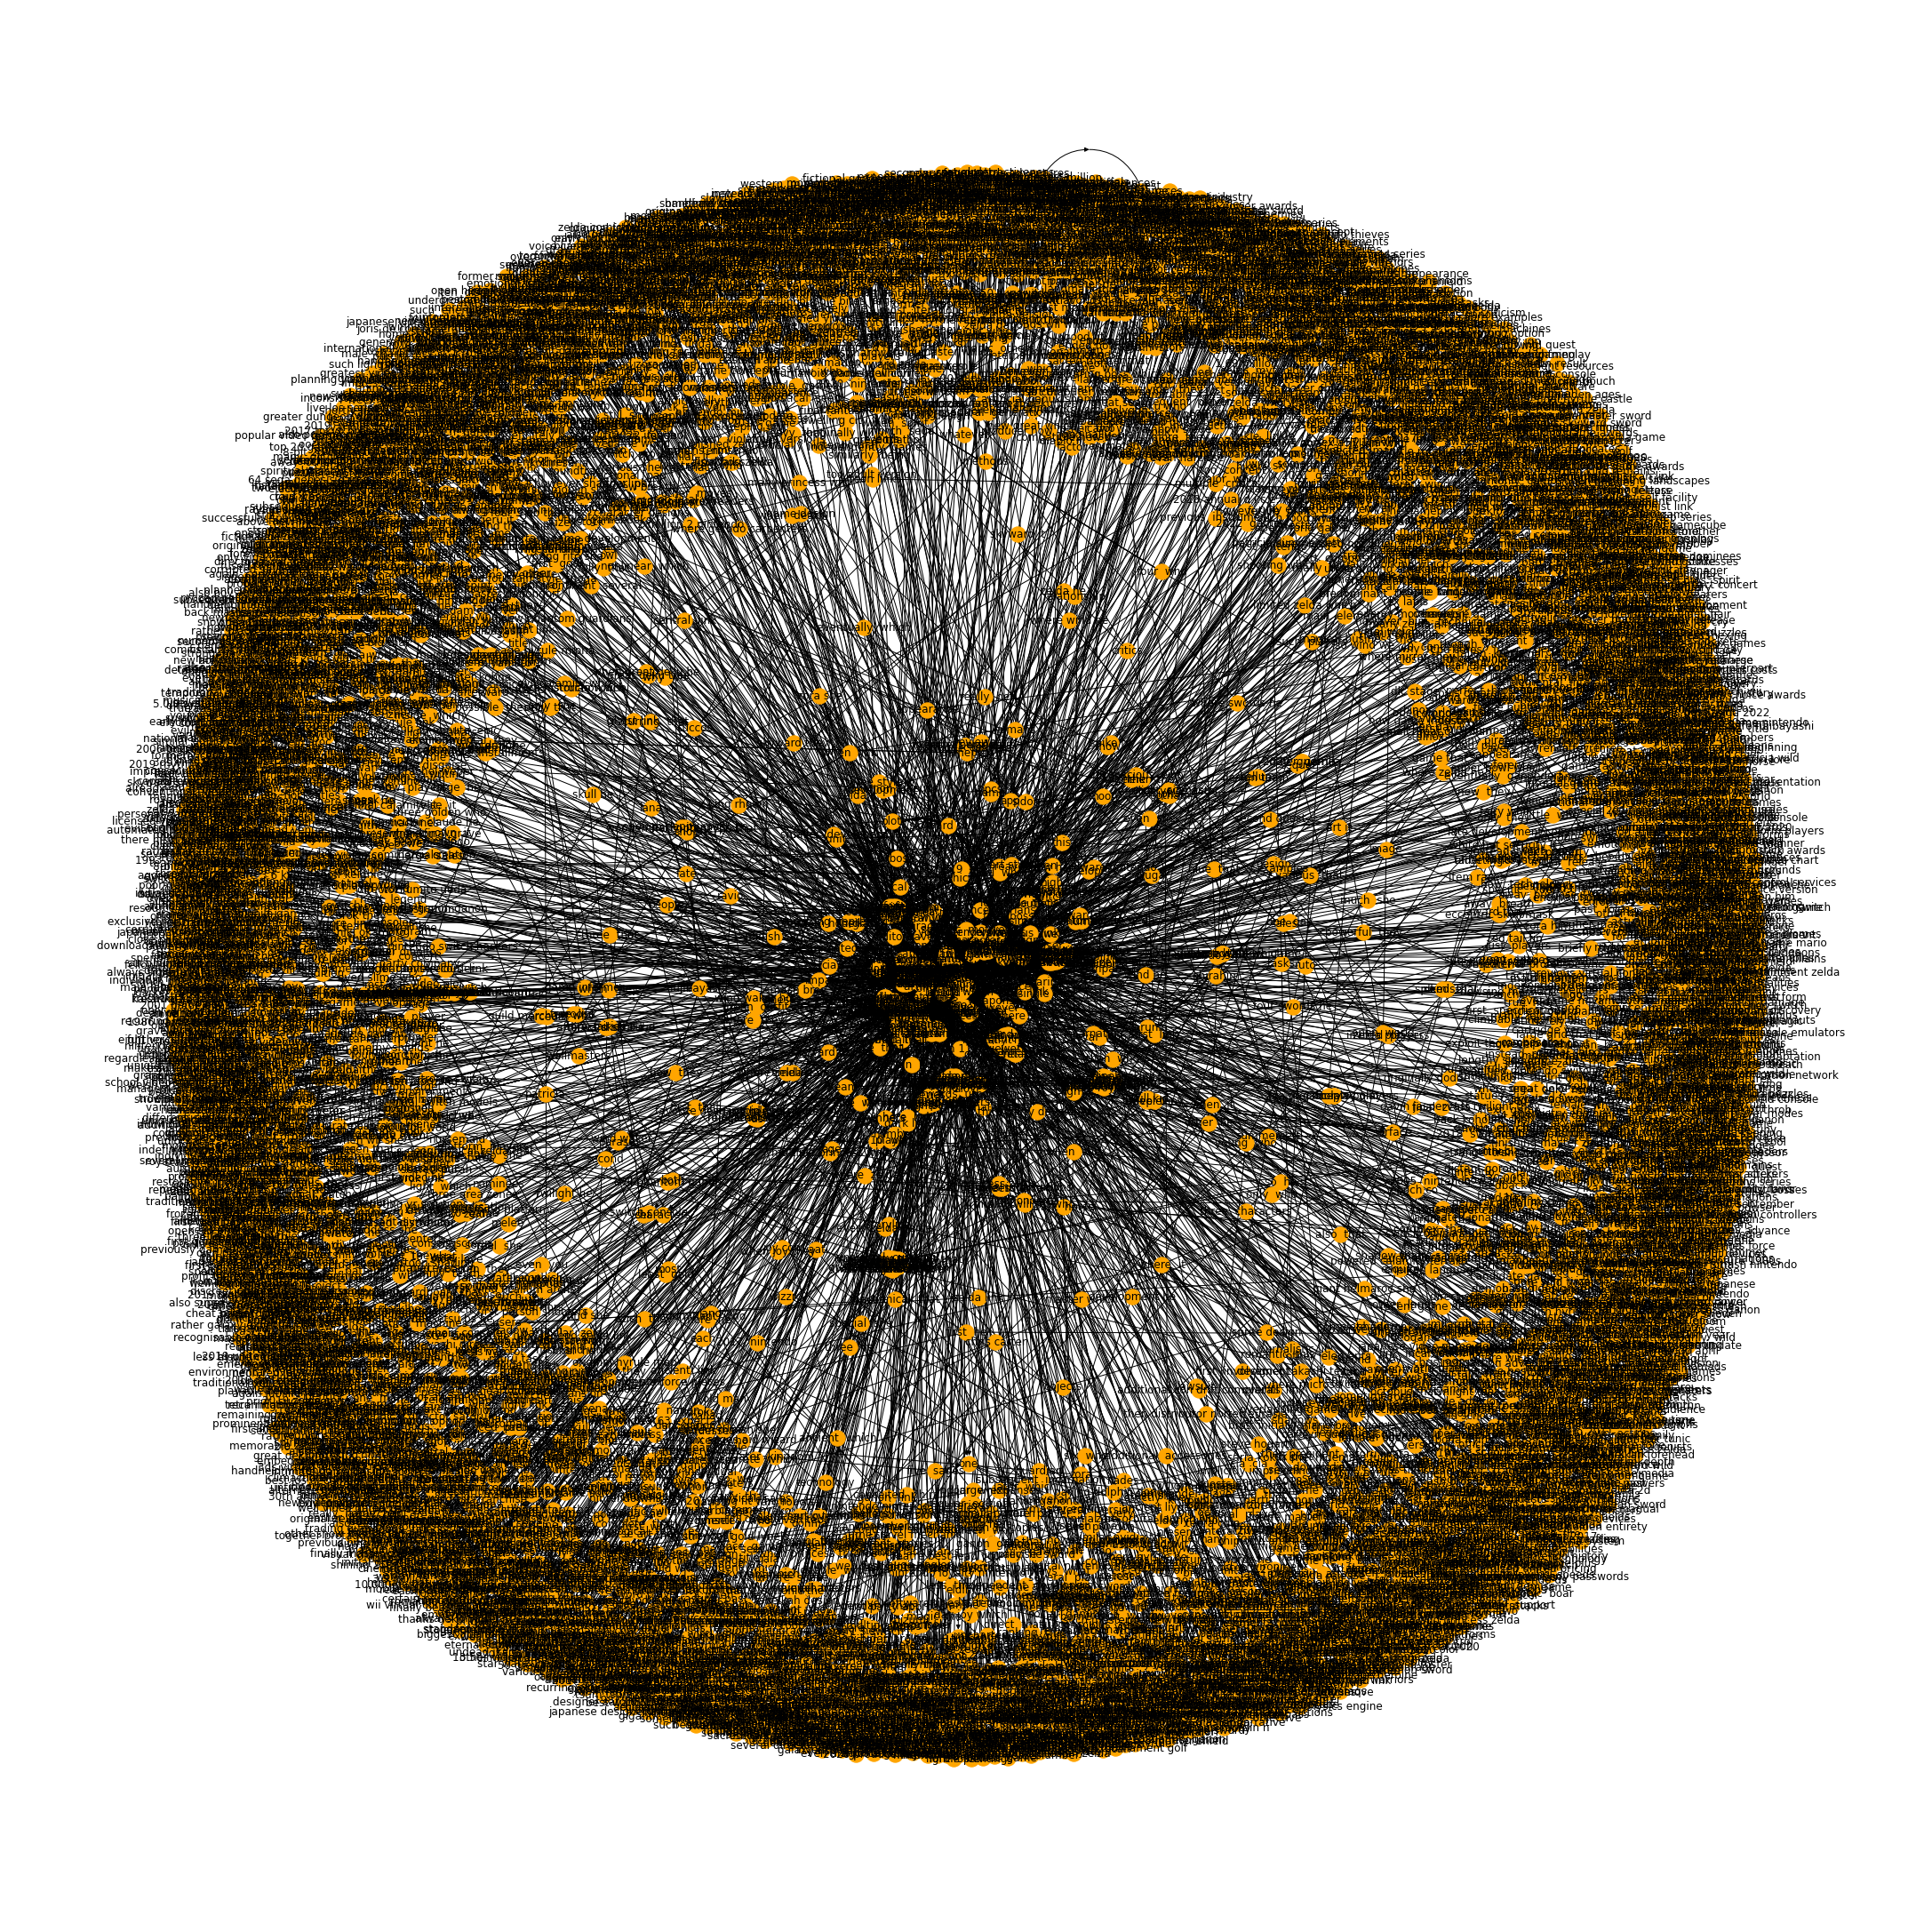

In [27]:
plt.figure(figsize=(30,30))
pos = nx.spring_layout(kgraph)
nx.draw(kgraph, with_labels=True,
        node_color='orange',
        edge_cmap=plt.cm.Blues,
        pos=pos)
plt.show()

In [54]:
edge_filter = kg_df['edge'] == 'controls'

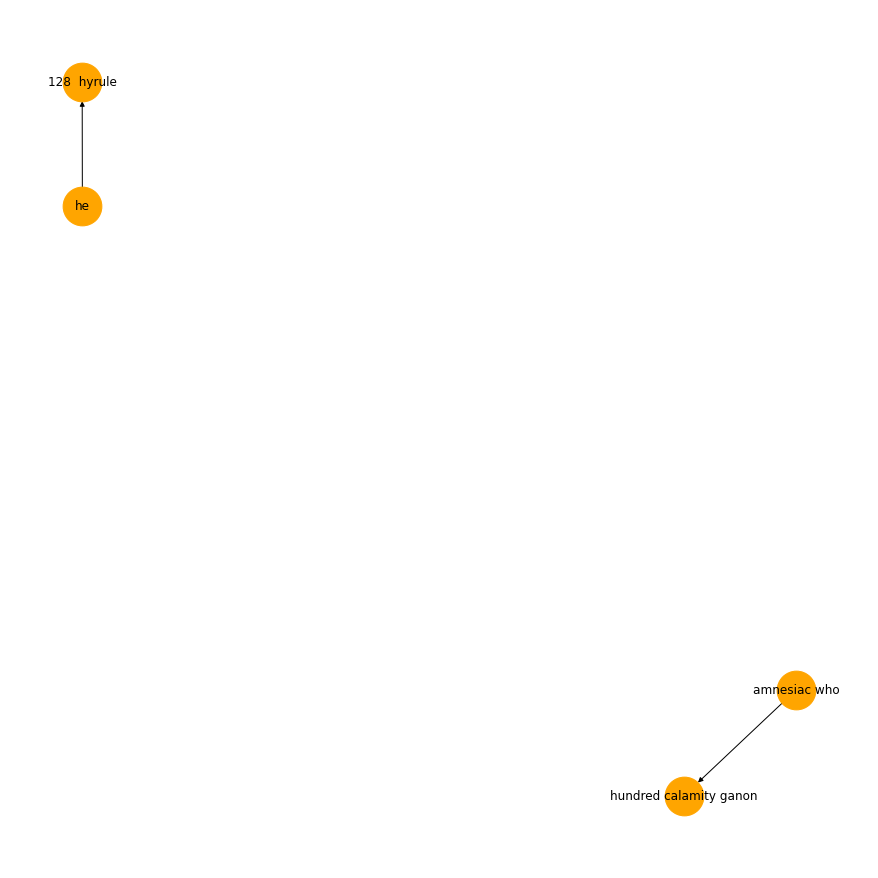

In [55]:
zoom_kgraph = nx.from_pandas_edgelist(kg_df[edge_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(zoom_kgraph, k=0.5) # k regulates the distance between nodes

nx.draw(zoom_kgraph, with_labels=True, 
        node_color='orange', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [39]:
target_filter = kg_df['target'] == 'zelda'

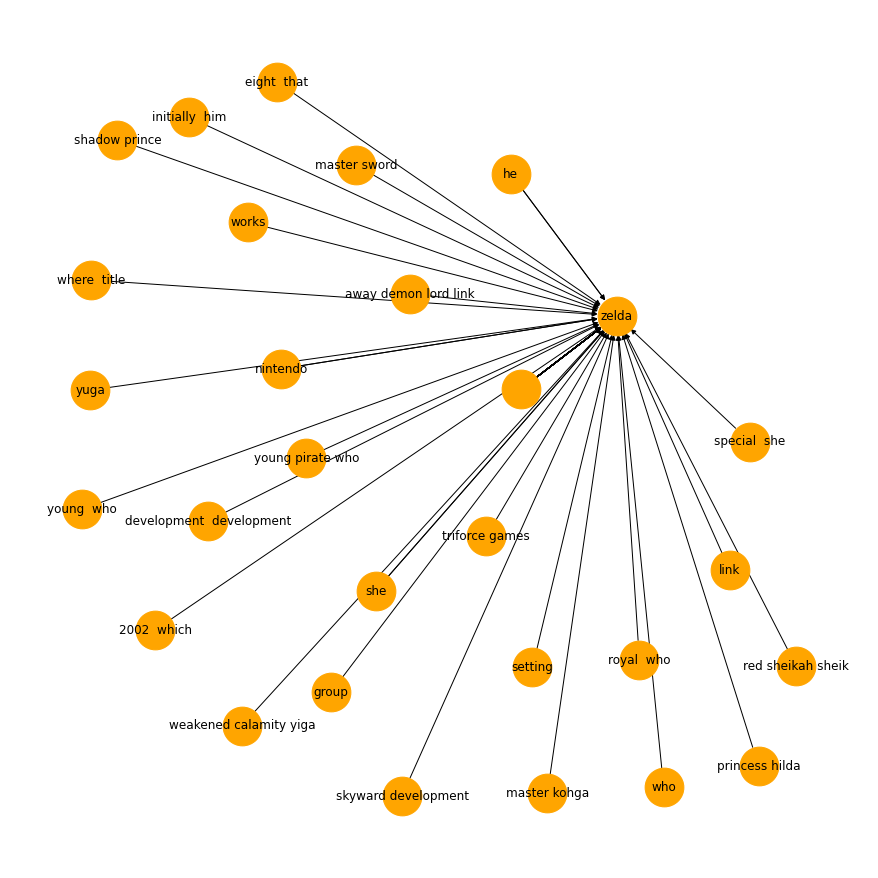

In [40]:
zoom_kgraph = nx.from_pandas_edgelist(kg_df[target_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(zoom_kgraph, k=0.5) # k regulates the distance between nodes

nx.draw(zoom_kgraph, with_labels=True, 
        node_color='orange', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [46]:
source_filter = kg_df['source'] == 'game'

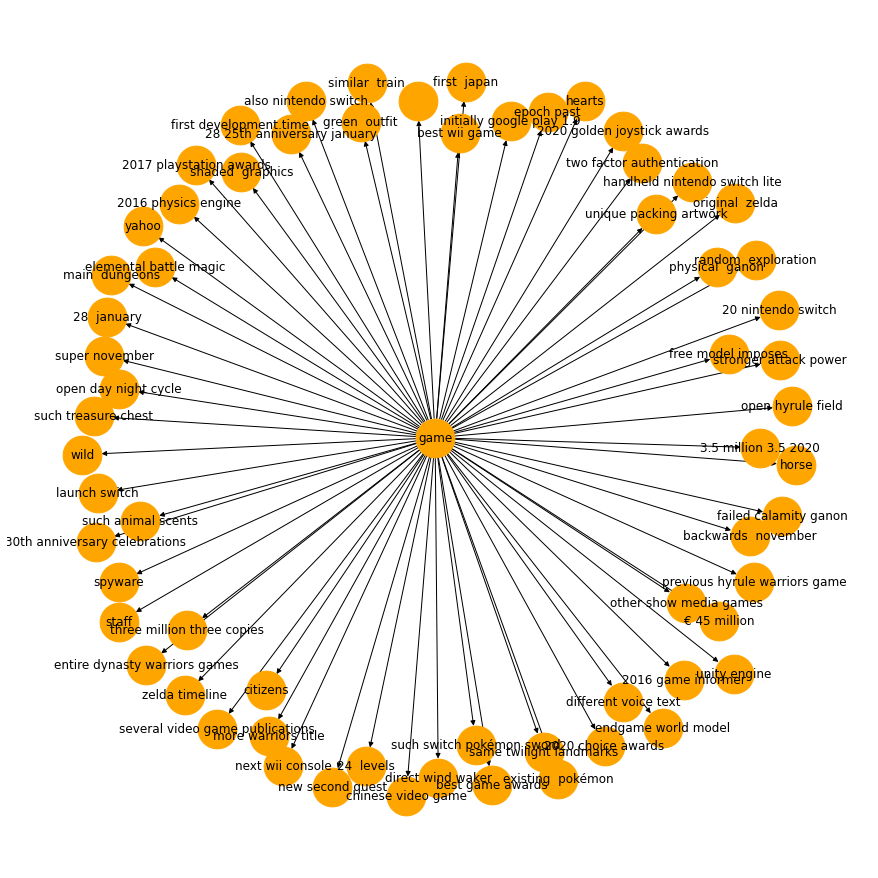

In [47]:
zoom_kgraph = nx.from_pandas_edgelist(kg_df[source_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(zoom_kgraph, k=0.5) # k regulates the distance between nodes

nx.draw(zoom_kgraph, with_labels=True, 
        node_color='orange', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [10]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = stopwords.words('english')
    stop_words = set(stop_words)
    tokens = [w for w in tokens if not w in stop_words]         
    # lemmatize
    wnl = WordNetLemmatizer()
    tokens=[wnl.lemmatize(word.lower()) for word in tokens]
    return tokens

In [11]:
df['tokens'] = df['doc_text'].apply(lambda x: clean_doc(x))

In [12]:
df.head()

doc_title  \
0            The Legend of Zelda: Breath of the Wild   
1  Untitled The Legend of Zelda: Breath of the Wi...   
2                                The Legend of Zelda   
3                    Universe of The Legend of Zelda   
4                   Hyrule Warriors: Age of Calamity   

                                            doc_text  \
0  The Legend of Zelda: Breath of the Wild is a 2...   
1  An untitled sequel to the 2017 action-adventur...   
2  The Legend of Zelda is a high fantasy action-a...   
3  The Legend of Zelda is a video game franchise ...   
4  Hyrule Warriors: Age of Calamity is a hack-and...   

                                              tokens  
0  [legend, zelda, breath, actionadventure, devel...  
1  [untitled, sequel, actionadventure, legend, ze...  
2  [legend, zelda, fantasy, actionadventure, vide...  
3  [legend, zelda, video, franchise, created, jap...  
4  [hyrule, warrior, calamity, hackandslash, vide...

In [13]:
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    inbound = bagofwords.fit_transform(data)
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    print(words_rank.head(10))
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10], palette = 'inferno')
    plt.title(title)
    
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


      word  count
8993   the   9366
6127    of   4577
587    and   3502
4553    in   3257
9098    to   3085
4821    is   1365
5273  link   1348
3771  game   1348
787     as   1345
8992  that   1175


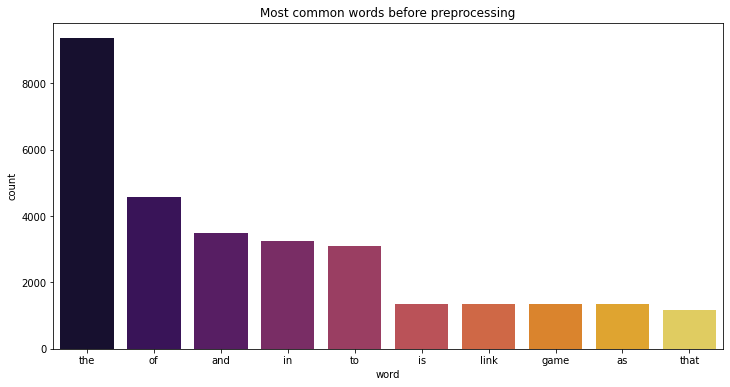

In [14]:
top10_bagofwords(df['doc_text'], 'most_common', 'Most common words before preprocessing')

In [15]:
#hmmmm why does it not like .lower.....
#top10_bagofwords(df['tokens'], 'most_common', "Top 10 most common words after preprocessing")

https://towardsdatascience.com/complete-guide-to-building-a-chatbot-with-spacy-and-deep-learning-d18811465876 

https://github.com/mtaruno/eve-bot 

https://www.youtube.com/watch?v=rlAQWbhwqLA&list=PL75e0qA87dlHQny7z43NduZHPo6qd-cRc 